In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import tweepy
import json
import os
from os import path
import re
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from PIL import Image
from wordcloud import WordCloud

In [5]:
df = pd.read_csv('archive_clean.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 25 columns):
Unnamed: 0               1994 non-null int64
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null float64
rating_denominator       1994 non-null float64
name                     1448 non-null object
dog_stage                326 non-null object
retweet_count            1994 non-null int64
favorite_count           1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1

In [8]:
df.tweet_id = df.tweet_id.astype(str)
df.dog_stage = df.dog_stage.astype("category")
df.timestamp = pd.to_datetime(df.timestamp)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 25 columns):
Unnamed: 0               1994 non-null int64
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null datetime64[ns, UTC]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null float64
rating_denominator       1994 non-null float64
name                     1448 non-null object
dog_stage                326 non-null category
retweet_count            1994 non-null int64
favorite_count           1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2        

In [10]:
df.retweet_count.describe()

count     1994.000000
mean      2762.679037
std       4732.483030
min         14.000000
25%        621.000000
50%       1342.000000
75%       3188.750000
max      78839.000000
Name: retweet_count, dtype: float64

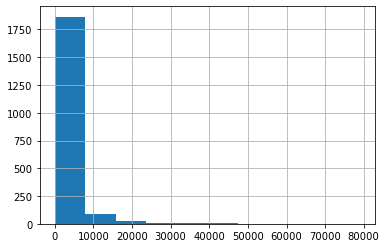

In [11]:
df.retweet_count.hist();

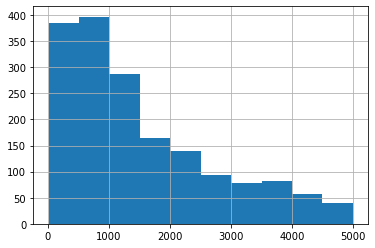

In [12]:
df[df.retweet_count <= 5000].retweet_count.hist();

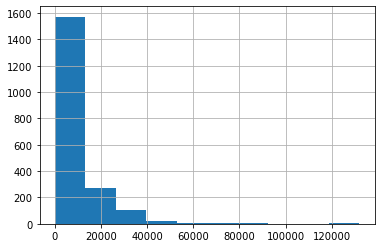

In [13]:
df.favorite_count.hist()

In [14]:
df.favorite_count.describe()

count      1994.000000
mean       8912.370612
std       12442.768857
min          81.000000
25%        1967.500000
50%        4109.000000
75%       11250.000000
max      131922.000000
Name: favorite_count, dtype: float64

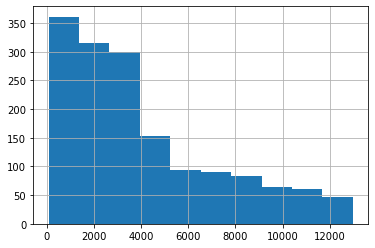

In [15]:
df[df.favorite_count <= 13000].favorite_count.hist()

In [16]:
# Most popular names
df.name.value_counts().head(10)

a          55
Charlie    11
Cooper     10
Lucy       10
Oliver     10
Tucker      9
Penny       9
Winston     8
Sadie       8
the         7
Name: name, dtype: int64

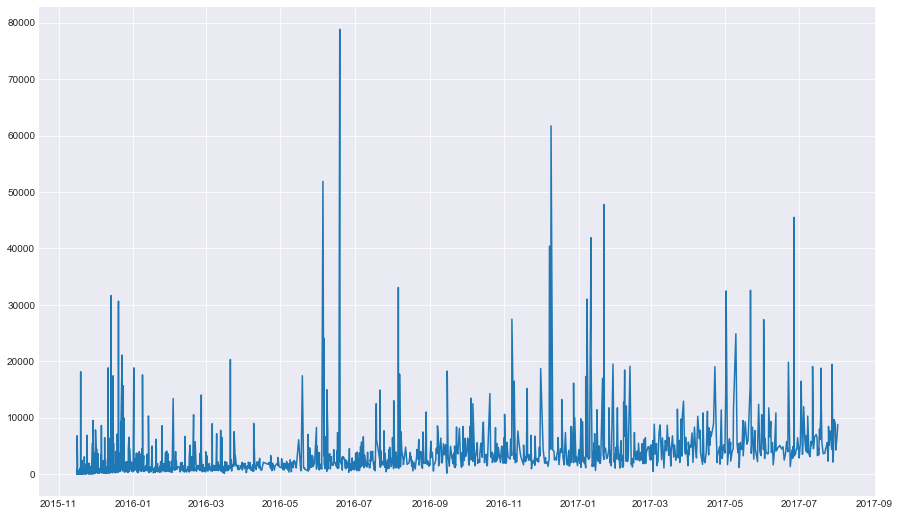

In [23]:
sns.set_context()
plt.subplots(figsize=(15, 9))
plt.plot(df.timestamp, df.retweet_count);


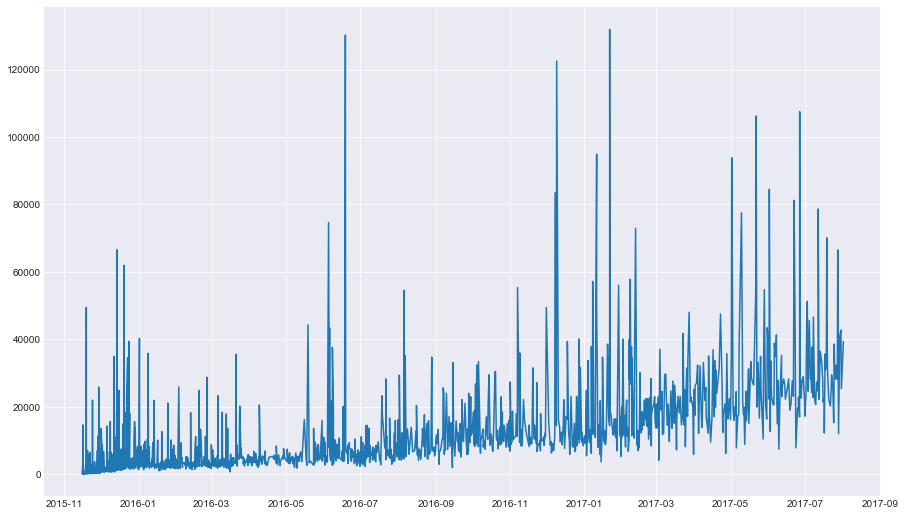

In [25]:
plt.subplots(figsize=(15, 9))
plt.plot(df.timestamp, df.favorite_count);

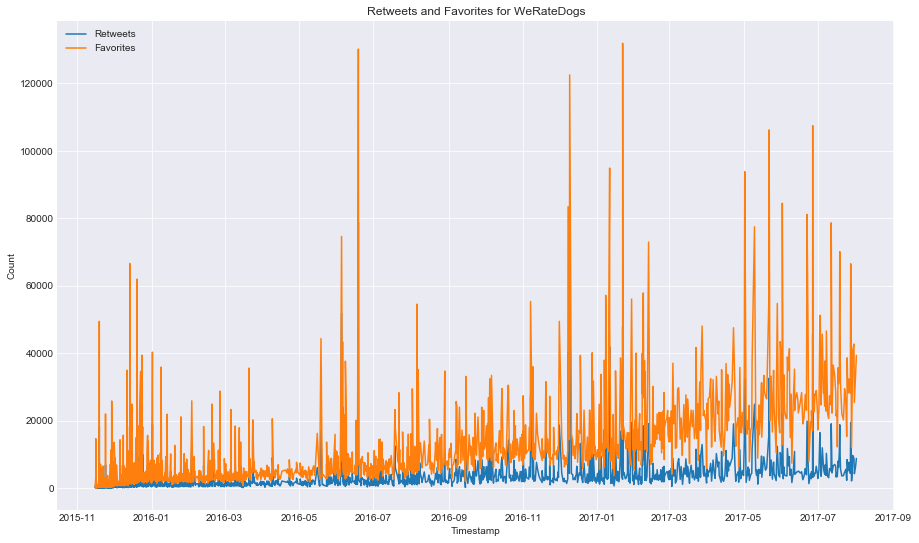

In [32]:
plt.subplots(figsize=(15, 9))
plt.plot(df.timestamp, df.retweet_count, label='Retweets')
plt.plot(df.timestamp, df.favorite_count, label='Favorites')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Retweets and Favorites for WeRateDogs')
plt.savefig('retweets_favorites.png');

In [33]:
dog_counts = df.groupby('dog_stage')['tweet_id'].count()
dog_counts

dog_stage
doggo       72
floofer      3
pupper     223
puppo       28
Name: tweet_id, dtype: int64

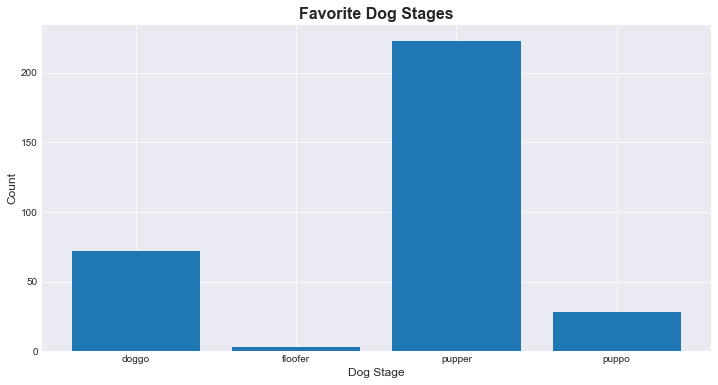

In [34]:
plt.subplots(figsize=(12, 6))
plt.bar([1, 2, 3, 4], dog_counts, tick_label=['doggo', 'floofer', 'pupper', 'puppo'])
plt.title('Favorite Dog Stages', fontsize=16, weight='bold')
plt.xlabel('Dog Stage', fontsize=12)
plt.ylabel('Count', fontsize=12);
plt.savefig('favorite-dogs.png')

In [39]:
# Find the index for the largest retweet_count
index = df.retweet_count.nlargest(5).index
# Get tweet details
rated_retweet = df[['tweet_id', 'text', 'name', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator', 'dog_stage']].iloc[index]
rated_retweet

,tweet_id,text,name,retweet_count,favorite_count,rating_numerator,rating_denominator,dog_stage
775,744234799360020481,Here's a doggo realizing you can stand in a po...,NaN,78839,130212,13.0,10.0,doggo
400,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,Stephan,61712,122529,13.0,10.0,NaN
810,739238157791694849,Here's a doggo blowing bubbles. It's downright...,NaN,51893,74622,13.0,10.0,doggo
309,822872901745569793,Here's a super supportive puppo participating ...,NaN,47768,131922,13.0,10.0,puppo
58,879415818425184262,This is Duddles. He did an attempt. 13/10 some...,Duddles,45511,107488,13.0,10.0,NaN


In [40]:
rated_retweet.describe()

,retweet_count,favorite_count,rating_numerator,rating_denominator
count,5.000000,5.000000,5.0,5.0
mean,57144.600000,113354.600000,13.0,10.0
std,13623.038512,23705.069032,0.0,0.0
min,45511.000000,74622.000000,13.0,10.0
25%,47768.000000,107488.000000,13.0,10.0
50%,51893.000000,122529.000000,13.0,10.0
75%,61712.000000,130212.000000,13.0,10.0
max,78839.000000,131922.000000,13.0,10.0


In [41]:
image = df[df.tweet_id == '744234799360020481']['jpg_url']
duplicated = image.duplicated()
image = image[~duplicated]
image.values[0]

'https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg'

In [42]:
url_list = []
for tweet_id in rated_retweet.tweet_id:
    image = df[df.tweet_id == tweet_id]['jpg_url']
    duplicated = image.duplicated()
    image = image[~duplicated]
    image_url = image.values[0]
    url_list.append(image_url)
    
url_list

['https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg',
 'https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg',
 'https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg',
 'https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg',
 'https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg']

In [43]:
"""
# Note: The code below is from 
# https://towardsdatascience.com/visualization-of-information-from-raw-twitter-data-part-1-99181ad19c
# I decided not to use it in my report as the findings for this data aren't very interesting
"""
#To see the most used hashtags.
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(df['text'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1


In [44]:
#Making a list of the most used hashtags and their values
hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#Separating the hashtags and their values into two different lists
hashtag_ordered_values = []
hashtag_ordered_keys = []
#Pick the 20 most used hashtags to plot
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])

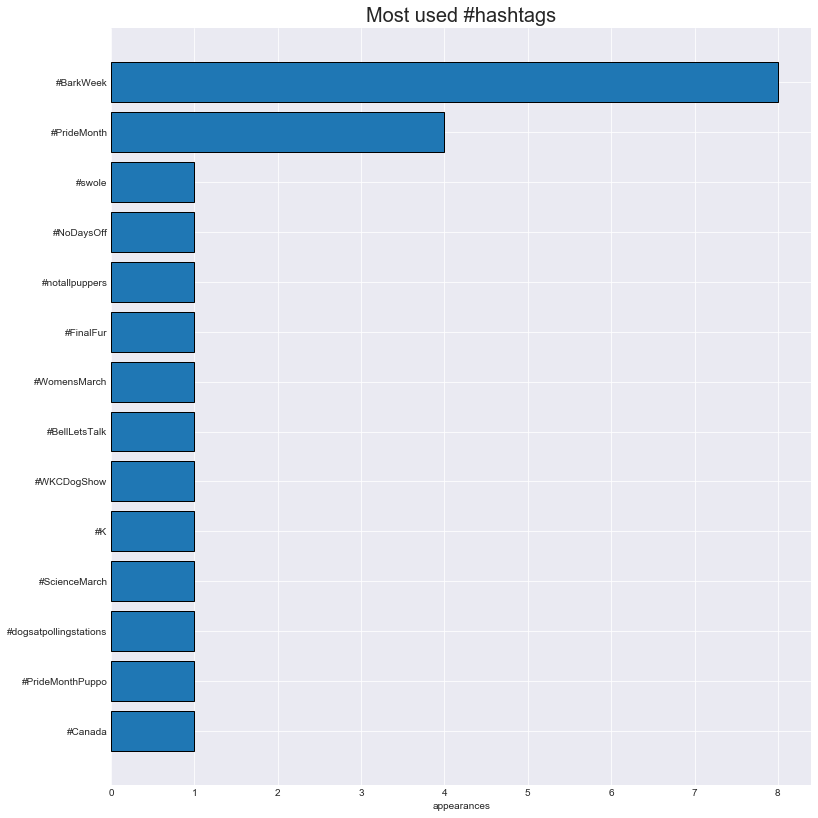

In [45]:
#Plotting a graph with the most used hashtags
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("appearances")
ax.set_title("Most used #hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [47]:
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(df['text'].apply(mention_pattern.findall))
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1

In [48]:
#Create an ordered list of tuples with the most mentioned users and #the number of times they have been mentioned
mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1])
mentions_ordered_list = mentions_ordered_list[::-1]
#Pick the 20 top mentioned users to plot and separate the previous #list into two list: one with the users and one with the values
mentions_ordered_values = []
mentions_ordered_keys = []
for item in mentions_ordered_list[0:20]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])

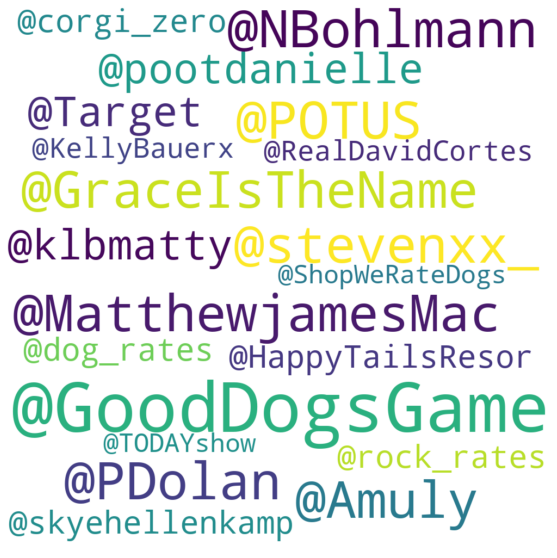

In [52]:
#Make a wordcloud representation for the most mentioned accounts too
mentions_ordered_dict = {}
for item in mentions_ordered_list[0:20]:
    mentions_ordered_dict[item[0]] = item[1]
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

In [56]:
df_text = df['text']
df_text.to_csv('df_text.csv')

/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


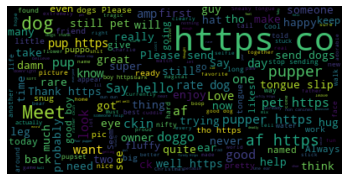

In [64]:
# Note: code below is from the wordcloud examples at https://amueller.github.io/

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'df_text.csv')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('text_wordcloud.png')
plt.show()

In [ ]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'df_text.csv')).read()

# read the mask image

dog_mask = np.array(Image.open(path.join(d, "dog.png")))

stopwords = set(STOPWORDS)
stopwords.add("https")

wc = WordCloud(background_color="white", max_words=2000, mask=dog_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "dog_word.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(dog_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [61]:
df_text = df['dog_stage']
df_text.to_csv('df_stage.csv')

/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


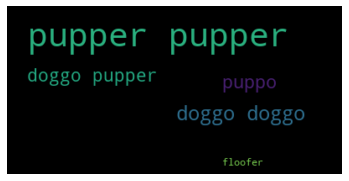

In [63]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'df_stage.csv')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('dog_stage_wordcloud.png')
plt.show()

In [66]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'df_stage.csv')).read()

# read the mask image

dog_mask = np.array(Image.open(path.join(d, "dog.png")))
dog_mask = dog_mask.convert("L") # convert image to black and white
dog_mask.mode = "L"
dog_mask = dog_mask.point(lambda x: 0 if x<128 else 255)

wc = WordCloud(background_color="white", max_words=2000, mask=dog_mask,
                contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "dog_stage.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(dog_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'convert'